### Licensing terms and copyright

This code builds on the Microsoft COCO Toolbox API version 2.0 for which data, paper, and tutorials are available at:  http://mscoco.org/. The MS COCO Toolbox was written by Piotr Dollar and Tsung-Yi Lin and licensed under the Simplified BSD license [see bsd.txt]

    Copyright (C) 2014 Piotr Dollar and Tsung-Yi Lin, Micosoft Corp.

The code contained in this project is protected by the terms and conditions of the
GNU_GPL-v3 copyleft license.

    Copyright (C) 2021 Cedric Bhihe and Barcelona Supercomputing Center (BSC)

This code is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or any later version.

This program is distributed in the hope that it will be useful, but WITHOUT
ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for
more details.

You should have received a copy of the GNU General Public License along with
this program.  If not, see <https://www.gnu.org/licenses/>, or consult the
License.md file in this repo.

To contact the author(s), use cedric dot bhihe at gmail dot com.

### Problem statement

This notebook does 1 things:

- it evaluates the average caption length for the MS COCO dataset.<BR>
Caption length is defined as the number of tokens making up the textual summary, barring punctuation.

### Installation requirements

**-- for a Linux Python 3.9.0 virtual environment --**

- Clone the COCO API ressources from the Github.com repo

```
$ pyenv install 3.9.0
$ mkdir -P <my_directory>
$ cd <my_directory>
$ pyenv local 3.9.0
$ git clone https://github.com/cocodataset/cocoapi
$ cd cocoapi/PythonAPI
$ sudo make install
# Below is optional, because already included in Makefile when `sudo make install`
$ sudo /usr/bin/python setup.py install 
```
- Install the following packages and their dependencies:

```
$ python -m pip install <<<- 'EOF'
    pandas==0.24
    seaborn==0.11.2
    matplotlib==3.3.3
    setuptools==51.0.0
    Cython==0.29.22
    pycocotools==2.0.3
    decorator==4.4.2
EOF
```
`pycocotools` requires `matplotlib`, `setuptools` and `Cython`.
Make sure they are installed in the same site-packages locations. 
For that you can verify where `pycotools` is installed by issuing:

```
$ python -m pip show pycocotools
```

or directly:

```
$ python -c "import site; print(site.getsitepackages()[0])"

```

- Go to https://cocodataset.org/#download and download the **"2017 Train/Val annotations [241MB]"** archive. The split train/val is now 118K/5K. 

- Compile jupyter kernel with ipykernel under name "mscocoapi" and label "Python3.9.0 (COCO-API)"

```
$ ipython kernel install --user --name mscocoapi --display-name "Python3.9.0 (COCO-API)"
```
- In the Jupyter notebook, do:
```
from pycocotools.coco import COCO
```

In [2]:
import sys, string, time, re
import multiprocessing as mp
from typing import Union, Any, List, Optional, cast

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from pycocotools.coco import COCO

In [3]:
## Check that the virtual environment Python version is correct.
#  (It will be if the correct Python kernel was chosen for this notebook.)

print(sys.executable)        # [Current iPython kernel's path] '/home/USER/.pyenv/versions/3.7.0/bin/python'
print(PYTHON_VERSION := sys.version_info[0:3]) # [Python version] 3
print(sys.stdout.encoding)  
#print(locale.getpreferredencoding())`

/home/ckb/.pyenv/versions/3.9.0/bin/python
(3, 9, 0)
UTF-8


In [4]:
data_dir = "/home/ckb/Documents/Work/Projects/Sgoab/Data/Annot_txt/Coco_en_2017/"

In [5]:
# Download training set and not the validation set for annotations
coco = COCO(data_dir + 'instances_train2017.json') 
caps = COCO(data_dir + 'captions_train2017.json')

loading annotations into memory...
Done (t=12.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!


In [7]:
categories = coco.loadCats(coco.getCatIds())
names = [cat['name'] for cat in categories] 

print("Available categories: ")
for index, n in enumerate(names):
    print("{}: {}".format(index, n), end=', ')

Available categories: 
0: person, 1: bicycle, 2: car, 3: motorcycle, 4: airplane, 5: bus, 6: train, 7: truck, 8: boat, 9: traffic light, 10: fire hydrant, 11: stop sign, 12: parking meter, 13: bench, 14: bird, 15: cat, 16: dog, 17: horse, 18: sheep, 19: cow, 20: elephant, 21: bear, 22: zebra, 23: giraffe, 24: backpack, 25: umbrella, 26: handbag, 27: tie, 28: suitcase, 29: frisbee, 30: skis, 31: snowboard, 32: sports ball, 33: kite, 34: baseball bat, 35: baseball glove, 36: skateboard, 37: surfboard, 38: tennis racket, 39: bottle, 40: wine glass, 41: cup, 42: fork, 43: knife, 44: spoon, 45: bowl, 46: banana, 47: apple, 48: sandwich, 49: orange, 50: broccoli, 51: carrot, 52: hot dog, 53: pizza, 54: donut, 55: cake, 56: chair, 57: couch, 58: potted plant, 59: bed, 60: dining table, 61: toilet, 62: tv, 63: laptop, 64: mouse, 65: remote, 66: keyboard, 67: cell phone, 68: microwave, 69: oven, 70: toaster, 71: sink, 72: refrigerator, 73: book, 74: clock, 75: vase, 76: scissors, 77: teddy bear

In [8]:
category_ids = coco.getCatIds(catNms=names)
image_ids = coco.getImgIds(catIds=category_ids)
images = coco.loadImgs(image_ids)
annIds = caps.getAnnIds(imgIds=image_ids)
annotations = caps.loadAnns(annIds)

In [24]:
# Split the annotations every 5 captions since there are 5 captions for each image
# Result: list of lists where embedded lists contains five dictionaries each, one 
# for each image_id caption.
#caps_alt = [annotations[x:x + 5] for x in range(0, len(annotations), 5)]
#print(caps_alt[:25])

[[{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}, {'image_id': 322141, 'id': 49, 'caption': 'A room with blue walls and a white sink and door.'}, {'image_id': 16977, 'id': 89, 'caption': 'A car that seems to be parked illegally behind a legally parked car'}, {'image_id': 106140, 'id': 98, 'caption': 'A large passenger airplane flying through the air.'}, {'image_id': 106140, 'id': 101, 'caption': 'There is a GOL plane taking off in a partly cloudy sky.'}], [{'image_id': 322141, 'id': 109, 'caption': 'Blue and white color scheme in a small bathroom.'}, {'image_id': 322141, 'id': 121, 'caption': 'This is a blue and white bathroom with a wall sink and a lifesaver on the wall.'}, {'image_id': 322141, 'id': 163, 'caption': 'A blue boat themed bathroom with a life preserver on the wall'}, {'image_id': 203564, 'id': 181, 'caption': 'The bike has a clock as a tire.'}, {'image_id': 16977, 'id': 185, 'caption': 'two cars parked on the sidewalk on t

In [25]:
# Lookup https://github.com/cocodataset/cocoapi/issues/120#issuecomment-552489530
# to explore datasets in more details

In [9]:
caps = [x['caption'].lower() for x in annotations]   # variable 'caps' == "captions"
#print(caps[.25])
len(caps)

591753

In [10]:
# Suppress punctuation
start = time.time()

caps_nopunc = [s.translate(s.maketrans('','',string.punctuation)) for s in caps]
print(len(caps_nopunc))
print('\n{}'.format(caps_nopunc[:5]))
time.time() - start

591753

['a bicycle replica with a clock as the front wheel', 'a room with blue walls and a white sink and door', 'a car that seems to be parked illegally behind a legally parked car', 'a large passenger airplane flying through the air', 'there is a gol plane taking off in a partly cloudy sky']


1.634366750717163

In [11]:
# Suppress punctuation
start = time.time()
caps_nopunc = [re.sub(r'[^\w\s]','',s) for s in caps]
print(len(caps_nopunc))
print('\n{}'.format(caps_nopunc[:5]))
time.time() - start

591753

['a bicycle replica with a clock as the front wheel', 'a room with blue walls and a white sink and door', 'a car that seems to be parked illegally behind a legally parked car', 'a large passenger airplane flying through the air', 'there is a gol plane taking off in a partly cloudy sky']


0.8534038066864014

In [12]:
# split sentences and count words
start = time.time()
caps_nopunc_wc = [len(x.split()) for x in caps_nopunc]
print(len(caps_nopunc_wc))
print('\n{}'.format(caps_nopunc_wc[:5]))
time.time() - start

591753

[10, 11, 13, 8, 12]


0.2819061279296875

In [55]:
# split sentences and count words
start = time.time()
caps_nopunc_wc = [len(re.findall(r'\w+', x)) for x in caps_nopunc]
print(len(caps_wc))
print('\n{}'.format(caps_nopunc_wc[:5]))
time.time() - start

591753

[10, 11, 13, 8, 12]


1.5986037254333496

                                                caps  wc
0  a bicycle replica with a clock as the front wheel  10
1   a room with blue walls and a white sink and door  11
2  a car that seems to be parked illegally behind...  13
3  a large passenger airplane flying through the air   8
4  there is a gol plane taking off in a partly cl...  12

Median caption word count: 10

                  wc
count  591753.000000
mean       10.454947
std         2.392038
min         5.000000
25%         9.000000
50%        10.000000
75%        11.000000
max        49.000000


Text(0, 0.5, '# of occurrences')

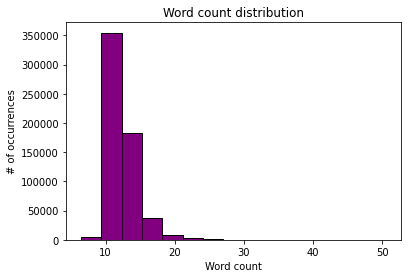

In [13]:
# Create dictionary of series -> panda dataframe
d = {'caps':pd.Series(caps_nopunc),'wc':pd.Series(caps_nopunc_wc)}
df = pd.DataFrame(d)
print(df[0:5])
sorted_caps_nopunc_wc = sorted(caps_nopunc_wc)
print('\nMedian caption word count: {}\n'.format(median_wc := sorted_caps_nopunc_wc[int(len(caps)/2)]))
print(df.describe())
plt.hist(df['wc'], bins=15, log=False, align='right', color='purple', edgecolor='black')
plt.title('Word count distribution')
plt.xlabel('Word count')
plt.ylabel('# of occurrences')

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /var/data/nltk_data/...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Elapsed processing time (s): 494.0
                                         caps_nopunc  nostop_wc
0  a bicycle replica with a clock as the front wheel          5
1   a room with blue walls and a white sink and door          6
2  a car that seems to be parked illegally behind...          8
3  a large passenger airplane flying through the air          5
4  there is a gol plane taking off in a partly cl...          6

Median captions' non-stop word count: 6

           nostop_wc
count  591753.000000
mean        5.767810
std         1.525536
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        31.000000


Text(0, 0.5, '# of occurrences')

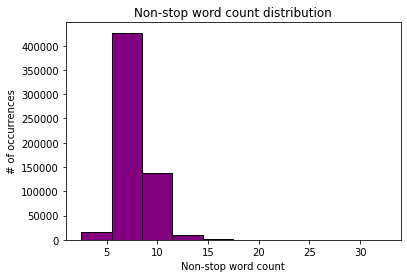

In [15]:
start = time.time()
caps_tmp = [x.split() for x in caps_nopunc]
caps_nopunc_nostop_wc = []
for cap in caps_tmp:
    caps_nopunc_nostop_wc.append(len([x for x in cap if not x in stopwords.words('english')]))

print('Elapsed processing time (s): {}'.format(round(time.time() - start,0)))

d = {'caps_nopunc':pd.Series(caps_nopunc),'nostop_wc':pd.Series(caps_nopunc_nostop_wc)}
df = pd.DataFrame(d)
print(df[0:5])

sorted_caps_nopunc_nostop_wc = sorted(caps_nopunc_nostop_wc)  
print('\nMedian captions\' non-stop word count: {}\n'.format(sorted_caps_nopunc_nostop_wc[int(len(caps_nopunc_nostop_wc)/2)]))

print(df.describe())

plt.hist(df['nostop_wc'], log=False, align='right', color='purple', edgecolor='black')
plt.title('Non-stop word count distribution')
plt.xlabel('Non-stop word count')
plt.ylabel('# of occurrences')

Core count: 8

Elapsed processing time (s): 145.0

                                         caps_nopunc  nostop_wc
0  a bicycle replica with a clock as the front wheel          5
1   a room with blue walls and a white sink and door          6
2  a car that seems to be parked illegally behind...          8
3  a large passenger airplane flying through the air          5
4  there is a gol plane taking off in a partly cl...          6

Median captions' non-stop word count: 6

           nostop_wc
count  591753.000000
mean        5.767810
std         1.525536
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        31.000000


Text(0, 0.5, '# of occurrences')

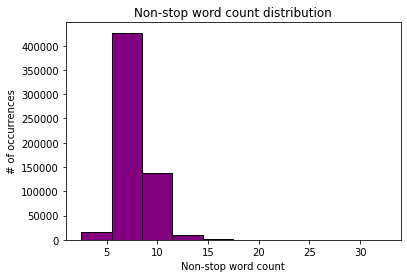

In [16]:
print('Core count: {}\n'.format(cc := mp.cpu_count()))

def len_caps_nostop(cap: str) -> int:
    """
    Function 'len_cap_nostop' eliminates English stop words from a sentence
    provided as input (sring).
    It outputs a stop-word free sentence length (integer).
    """
    return len([x for x in cap if not x in stopwords.words('english')])
    
if __name__ == "__main__":
    start = time.time()
    
    caps_nopunc_nostop_wc = []
    caps_tmp = [x.split() for x in caps_nopunc]
    
    with mp.Pool(processes=cc) as pool:
        caps_nopunc_nostop_wc = pool.map(len_caps_nostop, caps_tmp)
    
print('Elapsed processing time (s): {}\n'.format(round(time.time() - start,0)))

d = {'caps_nopunc':pd.Series(caps_nopunc),'nostop_wc':pd.Series(caps_nopunc_nostop_wc)}
df = pd.DataFrame(d)
print(df[0:5])

sorted_caps_nopunc_nostop_wc = sorted(caps_nopunc_nostop_wc)  
print('\nMedian captions\' non-stop word count: {}\n'.format(sorted_caps_nopunc_nostop_wc[int(len(caps_nopunc_nostop_wc)/2)]))

print(df.describe())

plt.hist(df['nostop_wc'], log=False, align='right', color='purple', edgecolor='black')
plt.title('Non-stop word count distribution')
plt.xlabel('Non-stop word count')
plt.ylabel('# of occurrences')